# The Portrayal of Actresses - What types of women are portrayed in movies?

In [76]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
from bs4 import BeautifulSoup as bs
import re
import gender_guesser.detector as gender
%matplotlib inline

In [77]:
data_folder = 'data/'
pickle_folder = data_folder + 'pickles/'

In [78]:
characters = pickle.load(open(pickle_folder + 'characters.p', 'rb'))
movies = pickle.load(open(pickle_folder + 'movies.p', 'rb'))

In [79]:
def plot_percentage_number_per_year(df, title, year, *args):
    df = df.loc[df[year].notna()]
    figure, ax = plt.subplots(1,2,figsize=(10,5))
    plt.suptitle(title)

    colours = sns.color_palette(n_colors=len(args) + 1)
    df_percentage = pd.DataFrame()
    df_abs = pd.DataFrame()
    df_abs['total_per_year'] = df[year].value_counts()

    for element in args:
        df_abs[element] = df.loc[df[element].notna()][year].value_counts().astype(float)
        df_percentage[element] = df_abs[element] / df_abs['total_per_year']
    df_abs.index = df_abs.index.astype(float)
    df_percentage.index = df_percentage.index.astype(float)

    ax1 = sns.lineplot(data=df_abs, ax=ax[0],palette=colours[-len(args)-1:], dashes=False)
    ax2 = sns.lineplot(data=df_percentage, ax=ax[1],palette=colours[-len(args):], dashes=False)
    ax1.set_title('Number of characters with specific feature')
    ax2.set_title('Percentage of characters with specific feature')
    ax1.set_xlabel('Years')
    ax2.set_xlabel('Years')
    ax1.set_ylabel('Number of characters')
    ax2.set_ylabel('Percentage of characters with feature')
    plt.show()

## Completeness of our data

We will briefly analyse the temporal completeness of our data

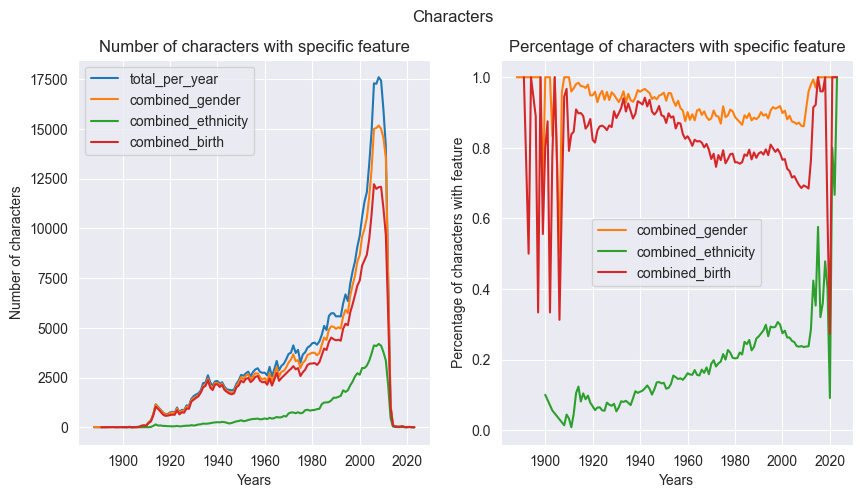

In [80]:
plot_percentage_number_per_year(characters, 'Characters', 'combined_release_year', 'combined_gender', 'combined_ethnicity', 'combined_birth')

Since we want to do an analysis over time, the plot above shows the completeness of actor gender ethnicity and birth over the years. Percentage of characters with specific feature (right graph) gets really noisy at both ends of our year spectrum. This is due to the small amount of movies in those time periods. Overall the gender and birth informations are around 80% complete around all years. Ethnicity on the other hand evolves significantly from older to newer films, and stays at lower completeness levels.

There are 1383 movies that released before 1915 (1.69% of total movies)
There are 1633 movies that released after 2011 (2.00% of total movies)


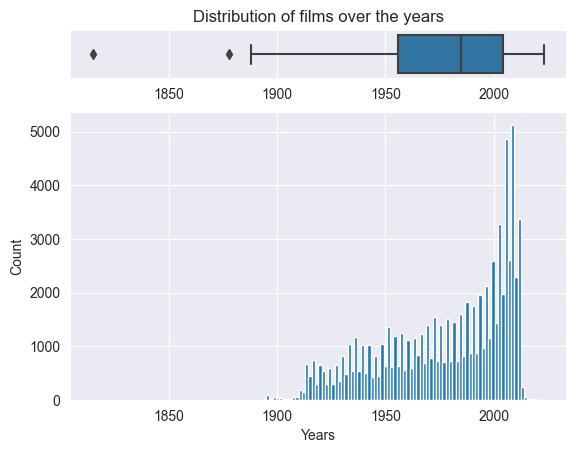

In [81]:
_, ax = plt.subplots(2,1, gridspec_kw={'height_ratios': [1, 6]})
ax1 = sns.boxplot(x = movies["combined_release_year"], ax = ax[0])
ax2 = movies["combined_release_year"].hist(bins = movies["combined_release_year"].nunique(), ax = ax[1])
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Years")

ax[0].set_title("Distribution of films over the years")
ax[0].set_xlabel("")

old_tresh = 1915
young_tresh = 2011

young = len(movies.loc[movies["combined_release_year"] > young_tresh])
young_ratio = (young/len(movies))*100
old = len(movies.loc[movies["combined_release_year"] < old_tresh])
old_ratio = (old/len(movies))*100

print(f"There are {old} movies that released before {old_tresh} ({old_ratio:.2f}% of total movies)\n"
      f"There are {young} movies that released after {young_tresh} ({young_ratio:.2f}% of total movies)")

Here we can see the distribution of films over the years. It is skewed towards more recent years. But there are few films that released before 1915 and after 2011, respectively 1.69% and 2%.

## How are presence and age evolving year by year?
The following analysis will be conducted using the dataset that was created by merging informations coming CMU dataset, IMDB and wikidata.


### Presence of women as actors

In [82]:
male_char = characters.loc[characters["combined_gender"] == "male"]
female_char = characters.loc[characters["combined_gender"] == "female"]
non_bin = characters.loc[(characters["combined_gender"] != "female") & (characters["combined_gender"] != "male") & (characters["combined_gender"]).notna()]
remaining = characters.loc[characters["combined_gender"].isnull()]

unique_male = (male_char["actor_name"].nunique())
unique_female = (female_char["actor_name"].nunique())
unique_non_bin = (non_bin["actor_name"].nunique())
unique_remaining = (remaining["actor_name"].nunique())

print(f"There are {unique_male} male actors in our dataset for a total of {len(male_char)} appearances = an average of {len(male_char)/unique_male:.2f} movies per man \n"
      f"There are {unique_female} female actors in our dataset for a total of {len(female_char)} appearances = an average of {len(female_char)/unique_female:.2f} movies per woman\n"
      f"There are {unique_non_bin} non-binary people in our dataset for a total of {len(non_bin)} appearances\n"
      f"We are missing the gender of {unique_remaining} actors gender infos for a total of {len(remaining)} appearances = an average of {len(remaining)/unique_remaining:.2f} movies per person")

There are 61231 male actors in our dataset for a total of 271200 appearances = an average of 4.43 movies per man 
There are 35950 female actors in our dataset for a total of 135184 appearances = an average of 3.76 movies per woman
There are 50 non-binary people in our dataset for a total of 266 appearances
We are missing the gender of 37221 actors gender infos for a total of 44019 appearances = an average of 1.18 movies per person


For this first analysis we are going to leave out non-binary people out, as they represent a small fraction of our dataset. In order to complete the dataset even more, we could try to infer the gender of actors based on their name, by using gender_guesser package for example. This would of course yield some incorrect results for some of the actors, but overall the accuracy should be good enough. These non-gendered actors seems  to have on average fewer films per actors (1.18), we think its because they are less important actors and that is also why we did not find their gender in our databases.

In addition. we see that the amounts of female and male actors are very different. We have 2 hypothesis to explain this difference:
* There is actually less women in the actors of film industry
* Actresses occupy less important roles, they might not get credited enough and end up not being present in the different datasets we used.

Let's see how this unbalance evolved year by year.

c:\Users\eliot\anaconda3\envs\ADA\lib\site-packages\seaborn\distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


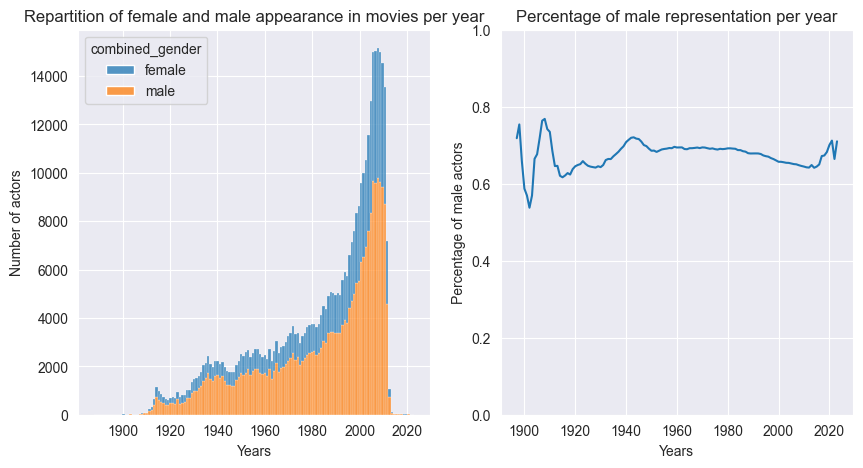

In [83]:
_, ax = plt.subplots(1,2,figsize = (10,5))

df = characters.loc[(characters["combined_gender"] == "female") | (characters["combined_gender"] == "male")]
ax1 = sns.histplot(data=df, stat="count", multiple="stack", x="combined_release_year", hue="combined_gender",ax = ax[0])

def find_ratio(df):
    return len(df.loc[df["combined_gender"] == "male"])/len(df)
male_v_female_repres = df.groupby("combined_release_year").apply(lambda x: find_ratio(x))

ax2 = sns.lineplot(male_v_female_repres.rolling(7).mean().T, ax = ax[1])
ax2.set_ylim([0,1])

ax1.set_title('Repartition of female and male appearance in movies per year')
ax2.set_title('Percentage of male representation per year')

ax1.set_xlabel('Years')
ax2.set_xlabel('Years')

ax1.set_ylabel('Number of actors')
ax2.set_ylabel('Percentage of male actors')
plt.show()

In [84]:
val = (len(df.loc[df["combined_gender"] == "male"])/len(df))*100
print(f"The average percentage of men across all the years in the total number of actors is {val:.2f}%")

The average percentage of men across all the years in the total number of actors is 66.73%


We can see from the graph that the percentage of man vs woman is the same across the years, except in the more recent and older films where we have quite a bit of noise, due to the lack of data. It seems that independently of the release year of the film, there are always more male actors that are present, or at least cited, this value stays in the neighborhood of the average 66% without any big jumps, except at both ends of the spectrum, this is again due to the lack of data.

### Actresses' age over the years

first a bit about the completeness of our data

In [85]:
df_births = df.loc[df["combined_birth"].notna()]
df_missing_births = df.loc[df["combined_birth"].isna()]

fn = lambda row: row.combined_release_year - row.combined_birth
col = df_births.apply(fn, axis=1)
df_births = df_births.assign(age=col.values)

unique_birth = df_births["actor_name"].nunique()

print(f"We have {unique_birth} actors who have a male/female gender and an age\n"
      f"this represemts {len(df_births)} entries\n"
      f"we are missing the birthdate of {len(df_missing_births)} male/female actors")

We have 59052 actors who have a male/female gender and an age
this represemts 348564 entries
we are missing the birthdate of 57820 male/female actors


We remove the actors who's age is smaller tham 0 and greater than 100.

In [86]:
df_births = df_births.loc[(df_births["age"] > 0) & (df_births["age"] < 100) ]

Let's look at the overall age difference

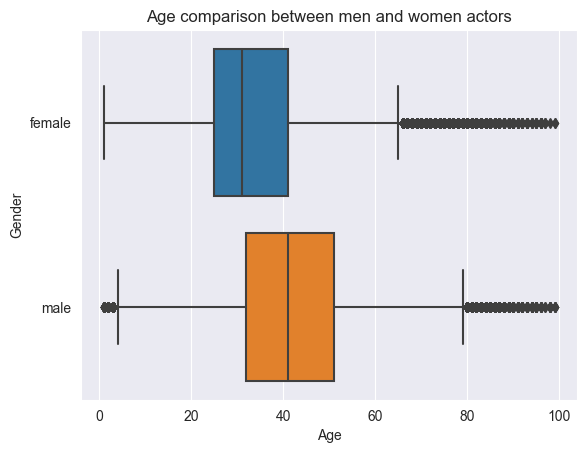

In [87]:
ax = sns.boxplot(data = df_births, x = "age", y = "combined_gender")
plt.title("Age comparison between men and women actors")
ax.set_xlabel("Age")
ax.set_ylabel("Gender")
plt.show()

From the plot above, we can see that there is an overall difference between male and female actors' age. The median age is different and the female age is skewed towards younger ages (other visualisation in following plots).

In [88]:
births_male = df_births[df_births["combined_gender"] == "male"]
births_female = df_births[df_births["combined_gender"] == "female"]

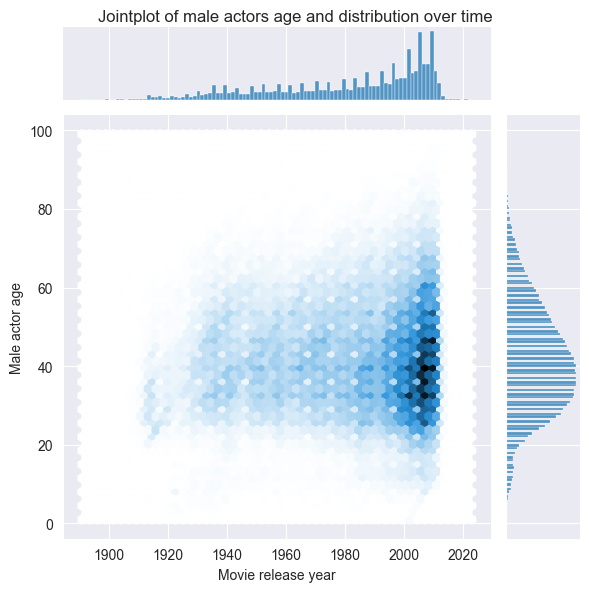

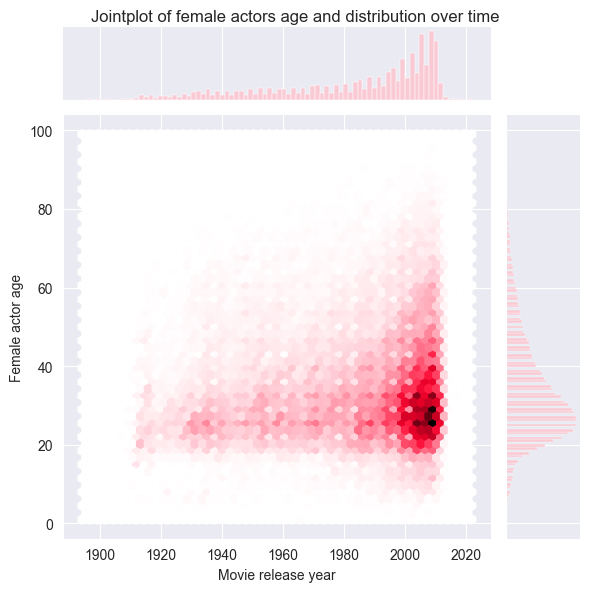

In [89]:
p = sns.jointplot(data=births_male, x = "combined_release_year", y = "age", kind = "hex")
p.fig.suptitle("Jointplot of male actors age and distribution over time")
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)

plt.xlabel('Movie release year')
plt.ylabel('Male actor age')

plt.show()

p = sns.jointplot(data=births_female, x = "combined_release_year", y = "age", kind = "hex", color = "pink")
p.fig.suptitle("Jointplot of female actors age and distribution over time")
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)

plt.xlabel('Movie release year')
plt.ylabel('Female actor age')

plt.show()

The distribution of women's age seems to be more skewed to towards smaller ages than men. Average men age is more spread out.

Let's see how this difference evolves over time.

In [108]:
avg_men_age = births_male.groupby("combined_release_year")["age"].mean()
avg_women_age = births_female.groupby("combined_release_year")["age"].mean()
avg_diff = (avg_men_age - avg_women_age).dropna()

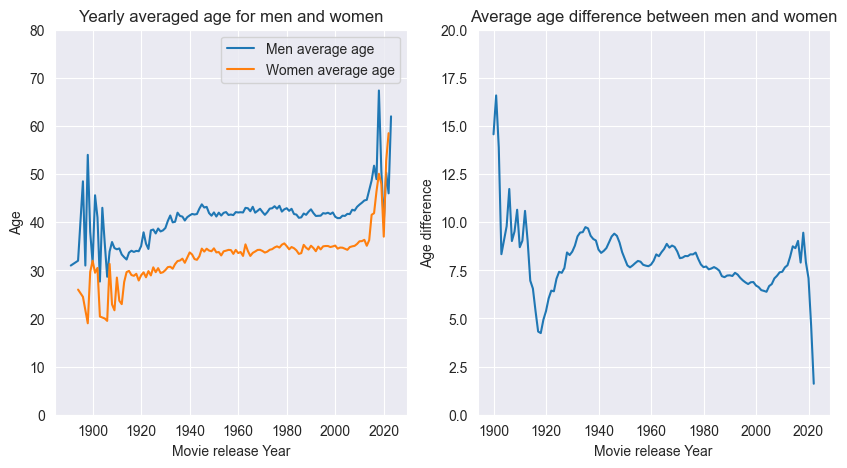

In [109]:
_, ax = plt.subplots(1,2,figsize = (10,5))

ax1 = sns.lineplot(avg_men_age.T, label = "Men average age", ax = ax[0])
ax2 = sns.lineplot(avg_women_age.T, label = "Women average age", ax = ax[0])
ax3 = sns.lineplot(avg_diff.rolling(5).mean().T, ax = ax[1])

ax2.set_ylim([0,80])
ax2.set_title("Yearly averaged age for men and women")
ax2.set_xlabel("Movie release Year")
ax2.set_ylabel("Age")

ax3.set_ylim([0,20])
ax3.set_title("Average age difference between men and women")
ax3.set_xlabel("Movie release Year")
ax3.set_ylabel("Age difference")

plt.show()

Since the noise is really important, we cut the extremes years for better visualisation

In [110]:
min = 1920
max = 2010
avg_men_age = avg_men_age.loc[avg_men_age.index.isin(np.linspace(min,max, num = max-min+1))]
avg_women_age = avg_women_age.loc[avg_women_age.index.isin(np.linspace(min,max, num = max-min+1))]
avg_diff = (avg_men_age - avg_women_age).dropna()

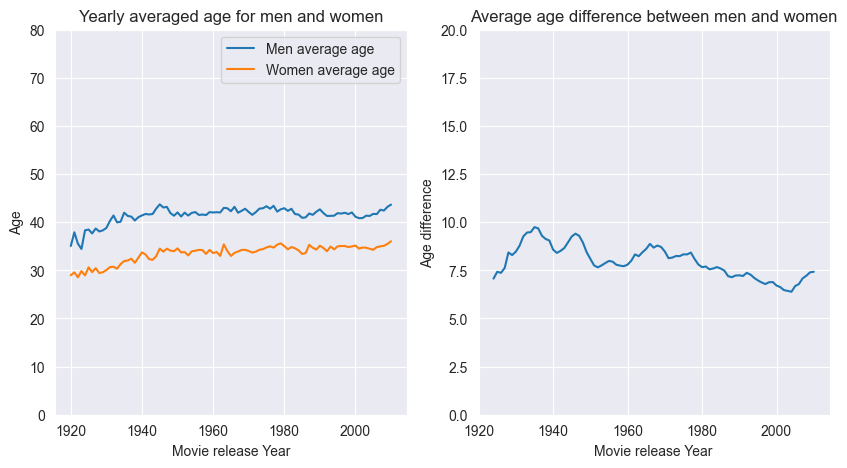

In [111]:
_, ax = plt.subplots(1,2,figsize = (10,5))

ax1 = sns.lineplot(avg_men_age.T, label = "Men average age", ax = ax[0])
ax2 = sns.lineplot(avg_women_age.T, label = "Women average age", ax = ax[0])
ax3 = sns.lineplot(avg_diff.rolling(5).mean().T, ax = ax[1])

ax2.set_ylim([0,80])
ax2.set_title("Yearly averaged age for men and women")
ax2.set_xlabel("Movie release Year")
ax2.set_ylabel("Age")

ax3.set_ylim([0,20])
ax3.set_title("Average age difference between men and women")
ax3.set_xlabel("Movie release Year")
ax3.set_ylabel("Age difference")

plt.show()

Men actors seem to be overall older than women actors, but it looks that the difference gets a bit smaller, when coming closer to the 2000's.

## Actresses and genre

In [107]:
merged_character = pd.merge(characters, movies, left_on='movie_freebase_id', right_on='freebase_id_cmu', how='left')

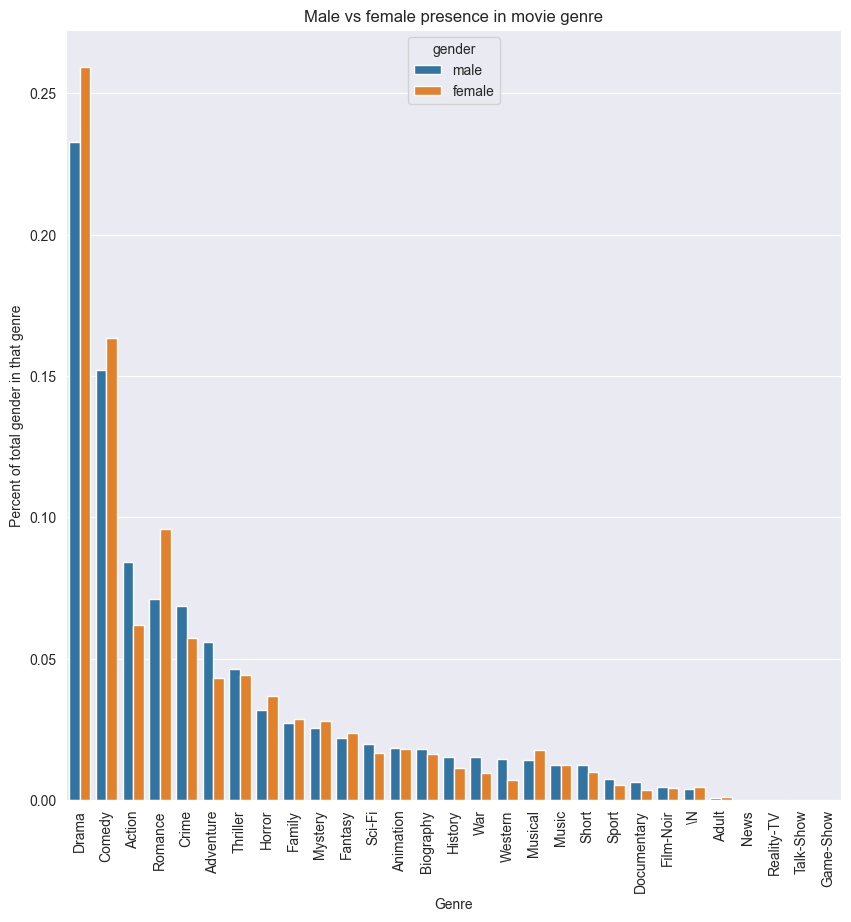

In [95]:
df = pd.DataFrame()
df2 = pd.DataFrame()
df['genre'] = merged_character.loc[merged_character.combined_gender == 'female'].genres_imdb.str.split(',').explode().value_counts() / len(merged_character.loc[merged_character.combined_gender == 'female'].genres_imdb.str.split(',').explode())
df['gender'] = 'female'
df2['genre'] = merged_character.loc[merged_character.combined_gender == 'male'].genres_imdb.str.split(',').explode().value_counts()/ len(merged_character.loc[merged_character.combined_gender == 'male'].genres_imdb.str.split(',').explode())
df2['gender'] = 'male'

df = pd.concat([df2, df])
df = df.reset_index()

fig, ax = plt.subplots(figsize=(10,10))

ax = sns.barplot(data=df, x='index', y='genre', hue='gender')
plt.xticks(rotation=90)
ax.set_title("Male vs female presence in movie genre")
ax.set_xlabel('Genre')
ax.set_ylabel('Percent of total gender in that genre')
plt.show()

This graph shows that females appear more in Drama, Comedy and Romance compared to men, who appear more in Action, Crime and Adventure.

## Are females equally represented in leading and minor roles?

In order to find the presence of women in major/minor roles we are considering their appearance in the credits of a film. The order of the credits can be considered as importance in the film, as first cast members will be the main actors, while following are less important. This order can be found on the "Full Cast & Crew" page of nearly all movies present on IMDB.

In [96]:
print(f"We have the imdb id of {movies.IMDB_id.dropna().count()} movies")

We have the imdb id of 74675 movies


We will get the index of the first woman cited in the credits, and see how this evolves over the years.

In [97]:
d = gender.Detector() #we initialize it outside the multiprocessing to gain time

In [98]:
def find_first_woman_index(gender_list, gender = "female"): #returns the index or nan if there are no women in the credits
    try:
        index_f = (gender_list.index(gender))
    except:
        index_f = np.inf
    try:
        index_mf = (gender_list.index("mostly_"+gender))
    except:
        index_mf = np.inf

    if index_f < index_mf:
        index = index_f
    else:
        index = index_mf

    if index == np.inf:
        index = np.nan

    return index

In [99]:
def get_gender_list(imdb_id, gender = "female"):
    r = requests.get(f"https://www.imdb.com/title/{imdb_id}/fullcredits?ref_=tt_ov_st_sm")
    soup = bs(r.text, 'html.parser')
    table = soup.find('table', class_='cast_list')
    first_name = 'img alt="[\w]+'
    if table is not None:
        m = re.findall(first_name, table.decode())
        gender_list = [d.get_gender(s.replace('img alt="', "")) for s in m] #we find the gender of the person using a gender detector package
        return [imdb_id, find_first_woman_index(gender_list, gender)+1]

    else:
        return [imdb_id, "no-cast"] #if the page does not exist

gender_list gives us the gender of the actors, and the order of the list is the order they appear in the movie's credits.


As this takes mutliple hours, we are going to showcase a result for the first 1000 imdb ids. The multiprocessing is run on a separate python file, mutliprocessing on windows doesn't work well inside notebooks.

In [100]:
imdb_id = movies.IMDB_id.dropna()
imdb_id = list(imdb_id)[:1000]
total_len = len(imdb_id)

#The multiprocessing was run in src/mutliproc.py

In [101]:
women_credit_rank = pd.DataFrame.from_records(pickle.load(open(pickle_folder+"women_appearance.p","rb"))).rename({0:"IMDB_id",1:"women_credit_rank"}, axis=1)
men_credit_rank = pd.DataFrame.from_records(pickle.load(open(pickle_folder+"men_appearance.p","rb"))).rename({0:"IMDB_id",1:"men_credit_rank"}, axis=1)
merged = (movies.merge(women_credit_rank, left_on="IMDB_id", right_on="IMDB_id")).merge(men_credit_rank, left_on="IMDB_id", right_on="IMDB_id")
merged = merged.loc[(merged["men_credit_rank"].notna()) & (merged["men_credit_rank"] != "no-cast")]

for i in range(int(merged.combined_release_year.min()), int(merged.combined_release_year.max())):
    year_low = i// 10 * 10
    year_high = year_low + 9
    merged.loc[merged.combined_release_year == i, 'group_year'] = f"{year_low} - {year_high}"

In [102]:
df = pd.DataFrame()
df['appearance'] = merged.women_credit_rank
df['gender'] = 'Female'
df["group_year"] = merged["group_year"]
df2 = pd.DataFrame()
df2['appearance'] = merged.men_credit_rank
df2['gender'] = 'Male'
df2["group_year"] = merged["group_year"]
df_final = pd.concat([df, df2])

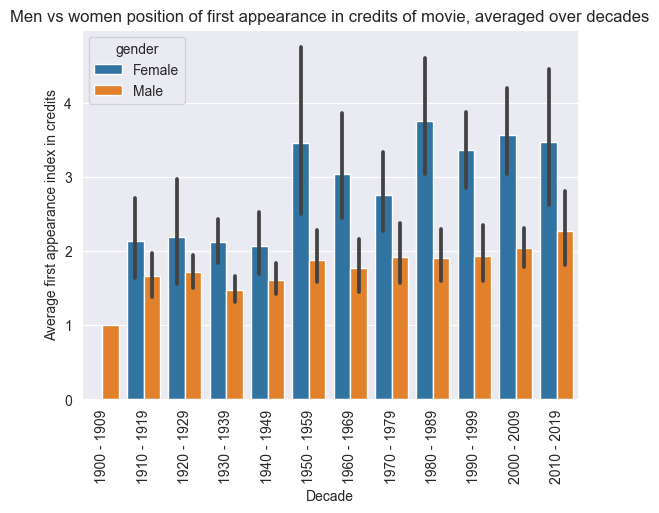

In [112]:
ax = sns.barplot(data = df_final.sort_values(by = "group_year"), x = "group_year", y = "appearance", hue = "gender")
plt.xticks(rotation = 90)
plt.title("Men vs women position of first appearance in credits of movie, averaged over decades")
ax.set_xlabel("Decade")
ax.set_ylabel("Average first appearance index in credits")
plt.show()

We can see on this plot that on average women are cited later in the credits compared to their male counterparts, meaning that they have less main roles.